In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import sys

dir_path = os.path.abspath('')
sys.path.append(dir_path + '/../')

from interpolazione import Interpolazione

dir_path = os.path.abspath('')
FILE = dir_path + '/data/' + 'RC.csv'
fr = pd.read_csv(FILE)

V = np.array(fr['V (V)'])
t = np.array(fr['t (us)']) * 10**-6
C = 0.000000099 # 0.1 nF
sigmaC = 0.000000001 # 0.1 nF
R = 996 # 10%
sigmaR = 0.1 * R
T = 2* (10**-3) # 2ms
sigmaV = 0.08 # /np.sqrt(12) # uniform distribution
Vg = 4.95 # V

$
V_r(t) = \frac{2V_g}{{1 + e^{-\frac{T}{2\tau}}}}e^{-\frac{t}{\tau}} 
$

where $\tau = R \cdot C$

In [2]:
def VR(t, τ):
    return 2*Vg*np.exp(-t/τ)/(1+np.exp(-T/(2*τ)))

i = Interpolazione(t,V,VR, 0.1, p0=[R*C])
print(i)

   
Parameters: [9.84708093e-05] 
Sigma parameters: [8.44887242e-07]

sigmaY: 0.1

chiquadro ridotto: 1.89
df: 41
pvalue: 100.0%
covariance matrix: [[6.80247003e-13]]    



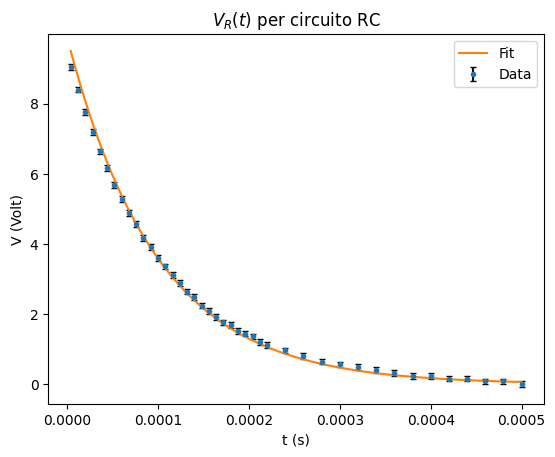

In [3]:
x = np.linspace(min(t), max(t), 1000)
y = VR(x, R*C)

plt.errorbar(t, V, yerr=sigmaV, fmt='.',ecolor='black',label='Data',capsize=2)
plt.plot(i.x_best,i.y_best,label='Fit')
# plt.plot(x,y)
plt.xlabel('t (s)')
plt.ylabel('V (Volt)')
plt.title('$V_R(t)$ per circuito RC')
plt.legend()
plt.show()

$
V_c(t) = V_g - V_r
$

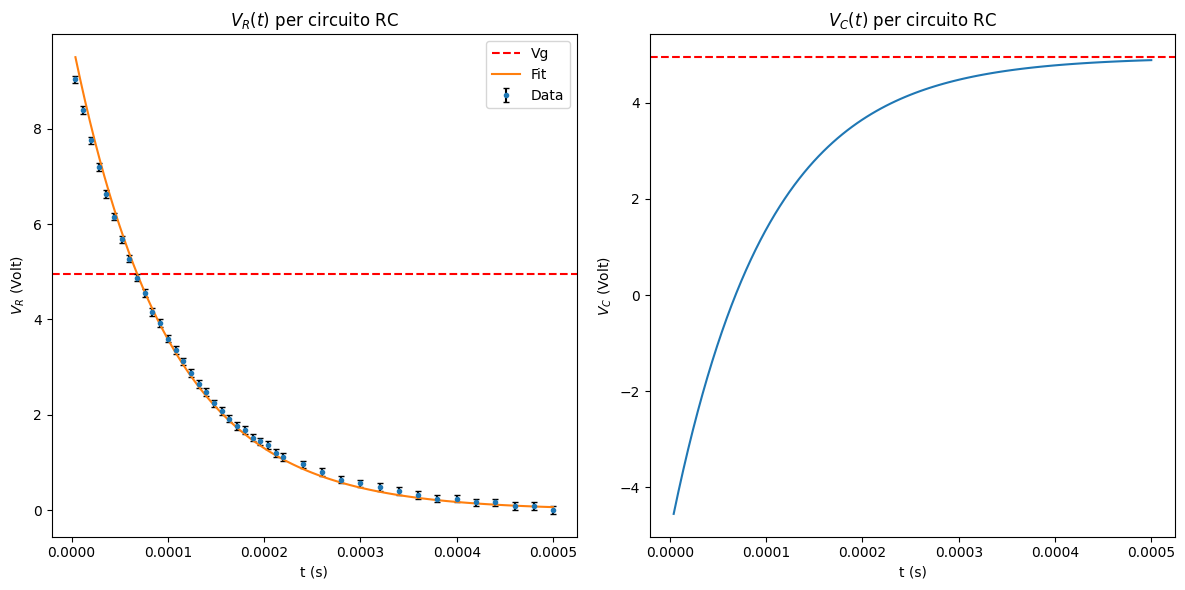

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
# Plot on the left
ax1.axhline(y=Vg, color='r', linestyle='--', label='Vg')
ax1.errorbar(t, V, yerr=sigmaV, fmt='.', ecolor='black', label='Data', capsize=2)
ax1.plot(i.x_best, i.y_best, label='Fit')
ax1.set_xlabel('t (s)')
ax1.set_ylabel('$V_R$ (Volt)')
ax1.set_title('$V_R(t)$ per circuito RC')
ax1.legend()

# Plot on the right
V_c = Vg - i.y_best
ax2.axhline(y=Vg, color='r', linestyle='--', label='Vg')
ax2.plot(i.x_best, V_c)
ax2.set_xlabel('t (s)')
ax2.set_ylabel('$V_C$ (Volt)')
ax2.set_title('$V_C(t)$ per circuito RC')

plt.tight_layout()
plt.show()